In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
jobs = ['Data scientist', 'Python', 'JS', 'Java','Data scientist', 'Python', 'JS', 'Java']
countrys = ['France','France','France','France', 'USA','USA','USA','USA']

# prendres tout les noms de fichiers csv dans le array
filenames = ['data/'+str.lower(job).replace(' ','')+str.lower(country)+'.csv' for job, country in zip(jobs,countrys) ]

# Créer le dataframe à partir de la concaténations de ces fichiers
df = pd.concat([pd.read_csv(filename, sep=';', encoding="utf-8-sig") for filename in filenames])

In [3]:
# Les mots clés des compétences
skills = ['Python', 'R', 'SQL', 'NoSQL', 'GIT', 'Spark', 'Flask', 'Streamlit', 'Docker', 'Kubernetes', 'React', 'Machine-Learning', 'Deep Learning', 'NLP', 'Vue', 'Angular', 'Scala', 'PySpark','PowerBI', 'SQLServer', 'Dataiku','Data', 'Keras', 'Tensor-Flow', 'NLU', 'PyTorch', 'Scikit-Learn', 'SAAS', 'Java', 'Scikit learn', 'Hadoop', 'Hive', 'ML','DL', 'Azure', 'AWS']

# contrats = ['CDI','CDD','Apprentissage','Contrat pro','Stage','Intérim','Freelance','Indépendant','Freelance']

# Les mots clés des niveaux d'études
studylevel_keywords = {'High School':['High School','Baccalauréat'],
                       'Guaduate': ['Université','Universitaire','Formation supérieure','Guaduate','Bac +2','Bac +3','Bachelor'],
                       'Master': ['Master','Master 2', 'Master +2', 'Bac +5', 'Grande école d\'ingénieur','Bac +4/5','M2','Cursus ingénieur', 'engineer','Diplôme ingénieur'],
                       'Doctor': ['Doctorat', 'Doctor'], 
                       'Formation': ['Formation Data Science']
                       }

# Les mots clés des niveaux d'expériences
explevel_keywords = {'Beginer':['Débutant', 'Beginer','No experience','Pas d`\'expérience', '1 an', '0-1 an','0 - 1 an', '0/1 an','0 / 1 an'],
                       'Intermediate': ['Intermédiaire','Intermediate','2 year', '3 year','2-3 year',  '2 ans', '2/3 an', '1-2 an','1-3  years'],
                       'Confirmed': ['Confirmé','Confirmed','3 an','4 an','5 an','3 year','4 year','5 year','3-5 year','3-5 an','3/5 year', '3/5 an'],
                       'Expert': ['Expert','6 year','7 year', '8 year', '9 year','6 an','7 an', '8 an','9 an','10 an','5-10 year','5-10 an','5 - 10 an','5/10 year', '5/10 an'],
                       'Senior': ['Senior', '10+ years', '10+ an', '10 ans +','plus de 10 an']
                       }

In [132]:
# La fonction vérifie si un terme existe dans une chaîne de caractère
def exist_in_array(x, dicto):

    for key in dicto:
        if any(str.lower(term) in str.lower(x) for term in dicto[key]):
            return key


# La fonction vérifie si dans la colonne ['Description'] de chaque ligne, s'il trouve descompétences dans le dictionnaire, si oui, il met un 1
def skill_required(row, skills):

    desc_low = str.lower(row['Description'])
    
    for skill in skills:

        skill_low = str.lower(skill)

        if (skill_low in desc_low) or (skill_low.replace(' ','') in desc_low) or (skill_low.replace('-','') in desc_low)  or (skill_low.replace('-',' ') in desc_low):
            row[skill] = 1

    return row

# La fonction retourne le résultat obtenu à partir d'un string et regex
def searchBy(x,pattern):
    match = re.search(pattern,str.lower(x))
    if match:
        return match.group(0)

# La fonction remplace valeurs nulles de la colonne ['Salaire'] par ['SalaryExtract'], si ['SalaryExtract'] n'est pas NaN
def replace_empty_salary(row):

    if row['SalaryExtract'] is not None: 
        if row['Salaire'] == 'None':
            row['Salaire'] = row['SalaryExtract']
        elif type(row['Salaire']) == float:
            row['Salaire'] = row['SalaryExtract']
        else:
            pass
    return row 


# Fonction qui retourne un numbre de format correcte à partir des nombres en format de string
def correct_number(string):
    numb_string = str(string).replace(' ','')

   # Si le nombre a un virgule devant les deux dernier chiffres 
    if re.match('^.+[.]\d{2}$',numb_string):
        numb = numb_string.replace(',','')
        return(float(numb))
        
   # Si le nombre a un point devant les deux dernier chiffres
    elif re.match('^.+[,]\d{2}$',numb_string):
        numb = numb_string.replace(',','.')
        return(float(numb))
    
   # Si le nombre n'a pas de point ni virgule devant les deux dernier chiffres
    else:
        numb = numb_string.replace(',','').replace('\.','')
        return(float(numb))


# fonction qui sépare les salaire minimum et salaire maximum en 2 colonnes différents
def minmaxSalary(row):
    match = re.match(r'(?:\D*)(?:[\$€]?\s?)((?:\d+)(?:[\.,\s]?\d{3})*(?:[\s]?k)?(?:[\.,\s]\d{2})?)(?:[\s]?[\$€]?[\s]?(?:à|au|et|\/|->?|to|and)?[\s]?[\$€]?\s?)((?:\d+)(?:[\.,\s]?\d{3})*(?:[\s]?k)?(?:[\.,\s]\d{2})?)?',row['Salaire'])

    # Si on obtient les salaire minimum et salaire maximum
    if (len(match.groups(0))==2) and (match.groups(0)[1] != 0):

        minSalary = correct_number(match.groups(0)[0])
        maxSalary = correct_number(match.groups(0)[1])

    # Si on obtient juste un salaire
    elif match.groups(0)[1] == 0:

        minSalary = correct_number(match.groups(0)[0])
        maxSalary = minSalary

    # Non retrouvé
    else:

        minSalary = np.nan
        maxSalary = np.nan

    #Si dans le salaire est indiqué le salaire par an
    if re.search(r'(annually)|(year)|(((par)|(per)|(by)|(\/)|(every)|(un)|(une))[\s]?an)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary
        row['Salaire maximum par an'] = maxSalary

    #Si dans le salaire est indiqué le salaire par mois
    elif re.search(r'(month)|(mensuel)|(mois)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary * 12
        row['Salaire maximum par an'] = maxSalary * 12

    #Si dans le salaire est indiqué le salaire par semaine
    elif re.search(r'(week)|(semaine)|(hebdomadaire)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary *4 * 12
        row['Salaire maximum par an'] = maxSalary *4 * 12
    
    #Si dans le salaire est indiqué le salaire par jour
    elif re.search(r'(day)|(jour)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary *22 * 12
        row['Salaire maximum par an'] = maxSalary *22 * 12
    
    #Si dans le salaire est indiqué le salaire par heure
    elif re.search(r'(hour)|(heur)',row['Salaire']):
        row['Salaire minimum par an'] = minSalary *8 * 22  * 12
        row['Salaire maximum par an'] = maxSalary * 8 * 22  * 12
        
    #pour tout autres cas return np.nan
    else:
        row['Salaire minimum par an'] = np.nan
        row['Salaire maximum par an'] = np.nan
    return row
         

# La fonction qui donne un array de quantile à partir de ['Salaire minimum par an'] et ['Salaire maximum par an']
def separe_quantile(df, number):
    list_prob = [ 1/number*i for i in range(1,number+1) ]
    array_min = df['Salaire minimum par an'].quantile(q=list_prob,interpolation="linear")
    array_max = df['Salaire maximum par an'].quantile(q=list_prob,interpolation="linear")
    
    liste_classe = [0]

    for i in range(number):
        liste_classe.append((array_min.values[i] + array_max.values[i])/2)

    liste_classe.pop()
    liste_classe.append(array_max.values[-1])
    return (liste_classe)


    # La fonction qui mets la classe de salaire de chaque ligne
def put_class_salaire(row,classes):
    mean = (row['Salaire minimum par an'] + row['Salaire maximum par an'])/2
    for i in range(len(classes)-1):
        if (classes[i] <= mean) and (mean <= classes[i+1]):
            row['Classe de salaire par an'] = str(int(classes[i]))+(' - ')+str(int(classes[i+1]))
    return row

In [5]:
# Extraire des niveaux d'étude requis à partir de la colonne ['Description']
df['Study required'] = df['Description'].apply(lambda x: exist_in_array(x, studylevel_keywords))

# Extraire des niveaux d'expérience requis à partir de la colonne ['Description']
df['Experience required'] = df['Description'].apply(lambda x: exist_in_array(x, explevel_keywords))

# Ajouter les colonnes de compétence et extraire la valeur à partir de la colonne ['Description']
df = pd.concat([df, pd.DataFrame(columns=skills)])
df = df.apply(lambda row: skill_required(row, skills), axis=1)

In [6]:
# Regex pour récupérer les chaînes pour indique les salaires
salaryMatch = re.compile(r'((([\$€]\s?\d+([\.,\s]?\d{3})*[\s]?k?([\.,\s]\d{2})?([\s]?((à)|(au)|(et)|(\/)|(->?)|(to)|(and))?[\s]?[\$€]?[\s]?\d{1,3}([\.,\s]?\d{3})*\s?k?([\.,\s]?\d{2})?)?)|((\d+([\.,\s]?\d{3})*\s?k?([\.,\s]\d{2})?\s?[\$€]?([\s]?((à)|(au)|(et)|(and)|(\/)|(->?)|(to))?[\s]?\d{1,3}([\.,\s]?\d{3})*\s?k?([\.,\s]\d{2})?)?)[€\$])[\s]?)(\s*(brut)?\s*((par)|(a)|(an)|(per)|(by)|(\/)|(every)|(un)|(une))[\s]*((annually)|(heure)|(jour)|(hebdomadaire)|(mois)|(mensuel)|(hour)|(day)|(month)|(year)|(an))))')

In [7]:
# Extraire des salaires à partir de la colonne  ['Description']
df['SalaryExtract'] = df['Description'].apply(lambda x: searchBy(x ,salaryMatch))

# Remplacer la colonne ['Salaire'] nulle par ['SalaryExtract'], si ['SalaryExtract'] est non nulle aussi
df = df.apply(lambda row: replace_empty_salary(row), axis=1)

# Supprimer les lignes dont le salaire n'ont pas de valeur
df = df[df['Salaire']!= 'None']

# Supprimer les lignes dont le salaire a NaN (les lignes erreur)
df['Salaire'].dropna(inplace=True)

# Supprimela colonne ['Type de contrat'] dont on n'a pas besoin
df.drop('Type de contrat', axis=1, inplace=True)

# Supprimela colonne ['SalaryExtract'] dont on n'a plus besoin
df.drop('SalaryExtract',axis=1, inplace=True)

# Supprimer les lignes doublants
df = df.drop_duplicates()

#Ajouter les colonnes ['Salaire minimum par an'] et ['Salaire maximum par an']
df = pd.concat([df, pd.DataFrame(columns=['Salaire minimum par an','Salaire maximum par an'])])

# Assigner les colonnes ['Salaire minimum par an'] et ['Salaire maximum par an'] par les valeurs de la colonne ['Salaire']
df = df.apply(lambda row: minmaxSalary(row), axis=1)

# Prend que des lignes dont la salaires est superireur à un certain numbre 
# df = df[df['Salaire minimum par an']>10000]

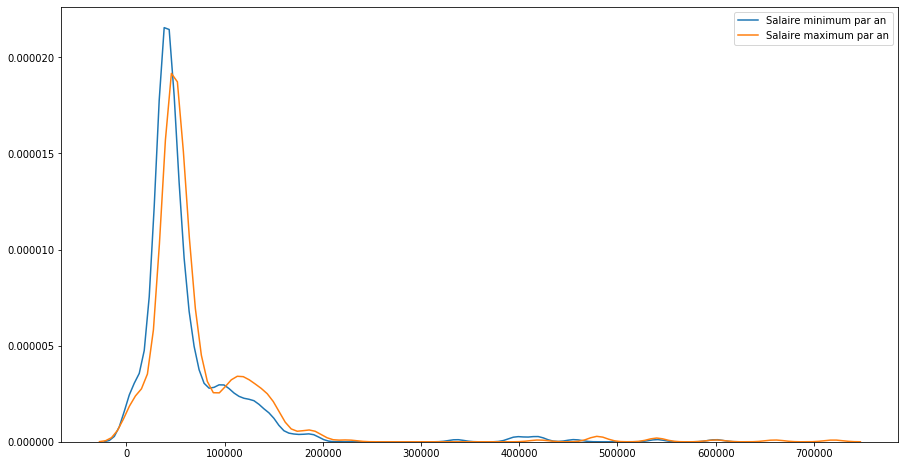

In [9]:
# df2 = df.sort_values('Salaire minimum par an')
import seaborn as sns

fig= plt.figure(figsize=(15,8))
# Make default density plot
p1 = sns.kdeplot(df['Salaire minimum par an'])
p2 = sns.kdeplot(df['Salaire maximum par an'])
#sns.plt.show()


In [15]:
min_salaire = pd.DataFrame(df['Salaire minimum par an'].value_counts().sort_index()/len(df))
min_salaire.columns=['Proba']

max_salaire = pd.DataFrame(df['Salaire maximum par an'].value_counts().sort_index()/len(df))
max_salaire.columns=['Proba']


In [16]:
proba_accru = [min_salaire.iloc[0]['Proba']]

for i in range(1,min_salaire.shape[0]):
    proba_accru.append(proba_accru[-1] + min_salaire.iloc[i]['Proba'])

No handles with labels found to put in legend.


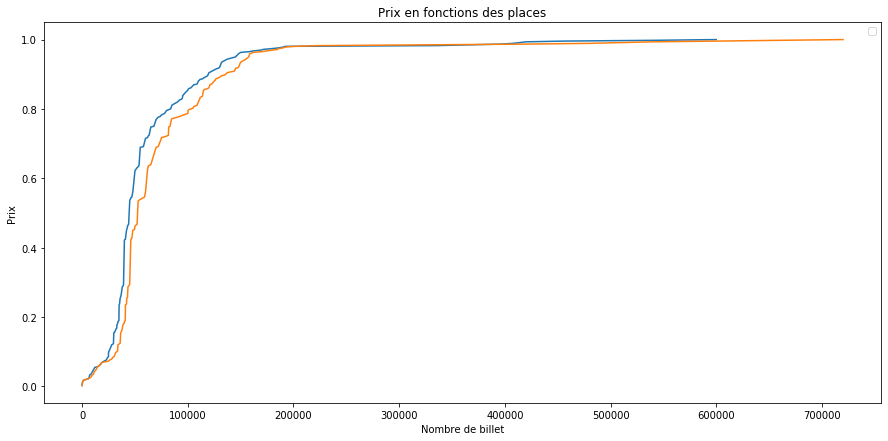

In [24]:
fig= plt.figure(figsize=(15,7))

p1 = plt.plot(min_salaire.index, proba_accru)
p2 = plt.plot(max_salaire.index, proba_accru)

plt.title('Prix en fonctions des places')
plt.xlabel('Nombre de billet')
plt.ylabel('Prix')
plt.legend()
plt.show()

In [124]:

df = df.apply(lambda row: put_class_salaire(row, separe_quantile(10)), axis=1)

In [130]:
# Supprimer les colonnes qu'on a plus besoin
df = df.drop(['Salaire','Salaire minimum par an', 'Salaire maximum par an'], axis=1)

KeyError: "['Salaire' 'Salaire minimum par an' 'Salaire maximum par an'] not found in axis"

In [131]:
df

,Poste,Entreprise,Pays,Ville,Description,Study required,Experience required,Python,R,SQL,...,SAAS,Java,Scikit learn,Hadoop,Hive,ML,DL,Azure,AWS,Classe de salaire
1,Data Scientist H/F,AGYLIS,France,La Défense (92),AGYLIS est un acteur important des Entreprise ...,Master,Beginer,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,45000€ - 49750€ par an
13,DATA SCIENTIST,Servier,France,Suresnes (92),VOS MISSIONS : QUI NOUS SOMMES : Servier est u...,Guaduate,Confirmed,1.0,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,1.0,NaN,1.0,1.0,65000€ - 94676€ par an
14,Data scientist / machine learning engineer (H/...,ABSIS CONSEIL,France,Fontenay-sous-Bois (94),Descriptif de la mission (au sein d'une équipe...,None,Expert,1.0,1.0,NaN,...,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,55000€ - 65000€ par an
20,Data Scientist / Experience analyst,LIVEMENTOR,France,Paris (75),À propos LiveMentor est la référence du coachi...,Master,Beginer,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45000€ - 49750€ par an
23,Data Scientist Confirmé,AGYLIS,France,Paris (75),AGYLIS est un acteur important des Entreprise ...,Master,Confirmed,1.0,1.0,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,37980€ - 42500€ par an
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,Sr. Software Engineer,GrayMatter Consulting Services,USA,"Alpharetta, GA 30004",Require: Bachelor's degree or a foreign equiva...,Guaduate,None,NaN,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94676€ - 127614€ par an
580,"Sr. Software Engineer - Full Stack, Angular an...",Amway Inc.,USA,"Ada, MI","Job title: Sr. Software Developer – Angular, J...",Master,Expert,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,94676€ - 127614€ par an
587,Senior Software Engineering Careers,Liberty Mutual Insurance,USA,"Boston, MA 02101",Thank you for considering software careers at ...,Master,Expert,NaN,1.0,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,127614€ - 720000€ par an
664,Senior Full Stack Developer,SCALAR,USA,"Draper, UT",Job Description Scalar is hiring a Senior Full...,Guaduate,Senior,1.0,1.0,1.0,...,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,94676€ - 127614€ par an
